## <font color=DarkTurquoise>Overall Goals</font>

<font color=Gray>The existence of the Transformers movie franchise raises a curious question: how can films that critics pan become massive box office successes, while critically acclaimed gems sometimes struggle commercially? This project explores the divide between critical and financial success in cinema, aiming to uncover what drives these differences. We’ll examine correlations between IMDb ratings and box office revenue to reveal general trends and identify outliers. Using a range of methodologies, from time-based and genre-specific analyses to sentiment analysis on plot summary, we aim to uncover patterns across genres, timeframes, and film attributes. Our approach integrates dataset merging, inflation-adjusted revenue comparisons, outlier classification, distribution analysis, and advanced sentiment modeling to answer our research questions and provide insight into this complex relationship between critics and audiences.</font>

## <font color=DarkTurquoise>Load Packages</font>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import json
import holoviews as hv
from holoviews import opts
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
import ast

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## <font color=DarkTurquoise>Load Datasets</font>

<font color=Gray>The `data/cleaned_data.csv` dataset contains data from two sources, described as follows:</font>

### <font color=Gray>Dataset1: CMU Dataset</font>

<font color=Gray>We load and preprocess two datasets related to `movies` and `characters`, making adjustments to ensure consistency and readability in the movie DataFrame. The main adjustments are as follows:

(1) We capitalized the first letter of each movie name, making all names follow title case with the first letter capitalized and the rest in lowercase.This step facilitates merging dataset1 and dataset2 by standardizing the movie names.

(2) We replaced any occurrences of the accented characters é and è with e.

(3) We created a column that has the year of the movie release so that we can remove duplicates that have the same name but different release year.

(4) We removed movies with empty or null values in the box office revenue column.

(5) We extracted the movie genres and languages into separate lists for storage.


Data source:http://www.cs.cmu.edu/~ark/personas/</font>

### <font color=Gray>Dataset2: IMBD Dataset</font>

<font color=Gray>We have introduced two new datasets: The `title.ratings`, which contains movie ratings and the number of voters, adding two new dimensions to our data. The `title.basics` dataset provides a mapping between IDs and movie names, helping us integrate these new dimensions into the original dataset. The main adjustments are as follows:

(1) We excluded movies with fewer than 30 reviews, as these films have too few ratings to objectively assess their quality. However, this step is open to discussion.

(2) We capitalized the first letter of all entries in the `primaryTitle` column to use as the primary key for merging with the CMU dataset, and then remove any unnecessary columns.

Data source:https://datasets.imdbws.com/</font>

In [17]:
#Load data
cleaned_data = pd.read_csv('data/cleaned_data.csv')
cleaned_data['Movie genres'] = cleaned_data['Movie genres'].apply(ast.literal_eval)
cleaned_data['Movie countries'] = cleaned_data['Movie countries'].apply(ast.literal_eval)

### <font color=Gray>Dataset3: US-CPI Dataset</font>

<font color=Gray>We first plotted the curve showing the variation in average annual box office revenue over time. Although there are some fluctuations, we can observe an overall upward trend in the curve.</font>

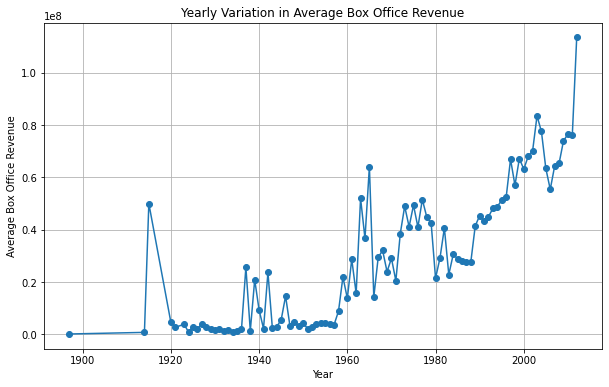

In [18]:
# Calculate the average box office revenue per release year
box_office_by_year = cleaned_data.groupby('Movie release year')['Movie box office revenue'].mean().reset_index()

# Set up the figure size for the plot
plt.figure(figsize=(10, 6))

# Plot the average box office revenue by release year, with markers on each point
plt.plot(box_office_by_year['Movie release year'], box_office_by_year['Movie box office revenue'], marker='o')

# Label the x and y axes
plt.xlabel('Year')
plt.ylabel('Average Box Office Revenue')

# Set the title for the plot
plt.title('Yearly Variation in Average Box Office Revenue')

# Add a grid for better readability
plt.grid(True)

# Display the plot
plt.show()


<font color=Gray>This phenomenon has several explanations. For instance, with the development of globalization, the number of cinemas has steadily increased worldwide. At the same time, advances in film production technology (such as 3D, IMAX) have enhanced the viewing experience. More theaters and improved viewing experiences attract a broader audience, driving box office revenue growth.

However, the primary factor we need to consider is that movie ticket prices have been rising each year due to `inflation`. This leads to an increase in total box office revenue, even if the number of moviegoers remains steady or slightly declines. Therefore, we need to adjust for inflation's effect on box office revenue and introduce the `US-CPI` index as a measure of inflation.</font>

In [20]:
# Load dataset
inflation = pd.read_csv('data/inflation.csv')

# Merge the inflation data with cleaned_data based on matching 'Year' and 'Movie release year' columns
cleaned_data = pd.merge(inflation, cleaned_data, left_on='Year', right_on='Movie release year', how='right').drop(columns=['CPI'])

# Calculate the adjusted revenue by multiplying 'Movie box office revenue' by the inflation 'rate'
cleaned_data['Adjusted_Revenue'] = cleaned_data['Movie box office revenue']*cleaned_data['rate']

<font color=Gray>We plotted a comparison of the average annual box office revenue before and after adjustment. It can be observed that the adjusted average annual revenue is higher than the original.</font>

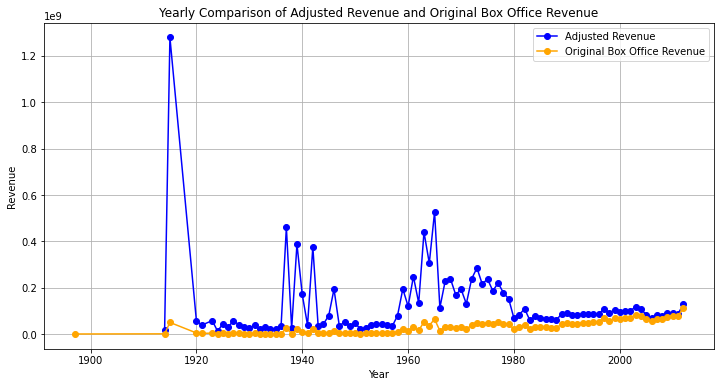

In [21]:
# Group by year and calculate the sum of both revenues per year
revenue_by_year = cleaned_data.groupby('Movie release year')[['Adjusted_Revenue', 'Movie box office revenue']].mean().reset_index()

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(revenue_by_year['Movie release year'], revenue_by_year['Adjusted_Revenue'], label='Adjusted Revenue', color='blue', marker='o')
plt.plot(revenue_by_year['Movie release year'], revenue_by_year['Movie box office revenue'], label='Original Box Office Revenue', color='orange', marker='o')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Yearly Comparison of Adjusted Revenue and Original Box Office Revenue')
plt.legend()
plt.grid(True)

# Display the chart
plt.show()

<font color=Gray>We observe that the average box office revenue is exceptionally high in certain years, and we are interested in these outliers. First, we will sort the years by average box office revenue in descending order to identify the top six.</font>

In [22]:
# Sort the DataFrame by 'Adjusted_Revenue' in descending order and select the top 5 rows
top_6_revenue = revenue_by_year.sort_values(by='Adjusted_Revenue', ascending=False).head(6)
top_6_years = top_6_revenue['Movie release year'].to_list()

In the line plot, we circle these outlier points to highlight them. It can be observed that most of these movies are from before 1970, making them old films!

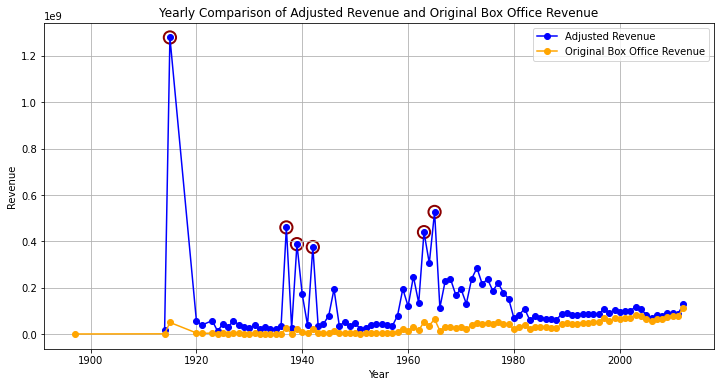

In [23]:
# Group by year and calculate the sum of both revenues per year
revenue_by_year = cleaned_data.groupby('Movie release year')[['Adjusted_Revenue', 'Movie box office revenue']].mean().reset_index()
years = revenue_by_year['Movie release year']
adjusted_revenue = revenue_by_year['Adjusted_Revenue']

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(revenue_by_year['Movie release year'], revenue_by_year['Adjusted_Revenue'], label='Adjusted Revenue', color='blue', marker='o')
plt.plot(revenue_by_year['Movie release year'], revenue_by_year['Movie box office revenue'], label='Original Box Office Revenue', color='orange', marker='o')
for year in top_6_years:
    if year in years.values:  # Check if the year is in the data
        revenue = adjusted_revenue[years == year].values[0]  # Get revenue value for the year
        plt.scatter(year, revenue, s=150, edgecolor='darkred', facecolor='none', linewidth=2)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Yearly Comparison of Adjusted Revenue and Original Box Office Revenue')
plt.legend()
plt.grid(True)

# Display the chart
plt.show()

We are particularly interested in the outlier for 1915 and have examined its details. This film, `The Birth of a Nation`, was directed by D.W. Griffith in 1915. Its high box office revenue can be attributed to both its controversial subject and pioneering filmmaking techniques. Additionally, the film had an unusually long theatrical run and was shown at higher ticket prices compared to typical films, which contributed significantly to its revenue. In 1915, the film industry was still in its early stages, and this movie faced almost no competition from other major productions (it is the only movie from 1915 in our dataset), allowing it to dominate the box office for an extended period.

In [24]:
filtered_data = cleaned_data[cleaned_data['Movie release year'] == 1915]
filtered_data

,Year,rate,averageRating,Wikipedia movie ID,Freebase movie ID,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Movie release year,startYear,Primary Country,Adjusted_Revenue
243,1915.0,25.591503,6.1,3333,/m/0151l,The birth of a nation,50000000.0,190.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac...",1915,1915,United States of America,1.279575e+09


It is these unique films that have impacted the trend of average annual box office revenue, but how to handle these outliers still require further discussion in the future.

## <font color=DarkTurquoise>Observe Distribution</font>

<font color=Gray>We first examine the joint distribution of the two main variables in our study: `box office revenue` and `ratings`. We can see that the distribution of box office revenue is right-skewed, mainly concentrated in the lower range. Therefore, we need to apply a logarithmic transformation to the box office revenue, which is beneficial for subsequent data processing.</font>

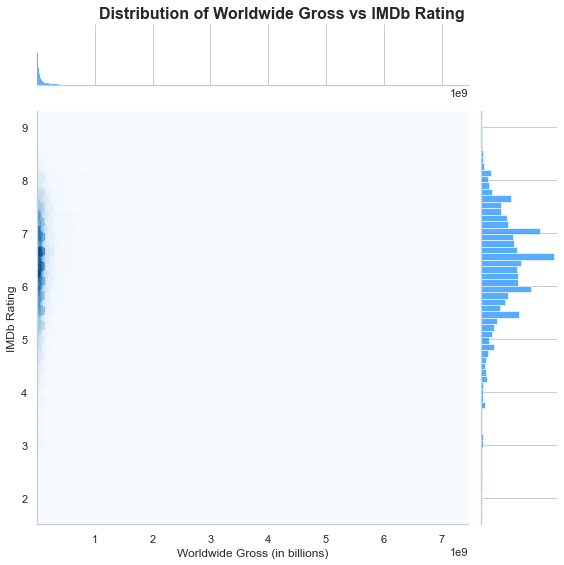

In [25]:
# Apply a log transformation (adding 1 to avoid log(0)) on the 'Movie box office revenue' column
# and store the result in a new column 'log_revenue_unjusted'
#cleaned_data['Log_Revenue_unadjusted'] = np.log1p(cleaned_data['Movie box office revenue'])

# Drop rows where 'Log_Revenue_unadjusted' contains NaN values to avoid missing data in the plot
cleaned_data.drop(cleaned_data[cleaned_data['Adjusted_Revenue'].isnull()].index, inplace=True)

# Set the Seaborn theme style to white grid and use a muted color palette
sns.set_theme(style="whitegrid", palette="muted")

# Create a joint plot with Seaborn, with a hexbin plot as the main part of the chart
g = sns.jointplot(data=cleaned_data, x='Adjusted_Revenue', y='averageRating', kind="hex", cmap="Blues", height=8, gridsize=50, marginal_kws=dict(color="dodgerblue"))

# Overlay a density contour plot in the center area of the joint plot to show distribution contours
sns.kdeplot(data=cleaned_data, x='Adjusted_Revenue', y='averageRating', cmap="Blues", fill=True, alpha=0.4, ax=g.ax_joint)

# Set the margins of the chart to fill the light blue background
g.ax_joint.margins(0)  
g.ax_joint.set_xlim(cleaned_data['Adjusted_Revenue'].min(), cleaned_data['Adjusted_Revenue'].max())
g.ax_joint.set_ylim(cleaned_data['averageRating'].min(), cleaned_data['averageRating'].max())

# Set the title and labels of the plot and adjust the plot
g.fig.suptitle("Distribution of Worldwide Gross vs IMDb Rating", fontsize=16, weight='bold', ha='center')
g.set_axis_labels("Worldwide Gross (in billions)", "IMDb Rating", fontsize=12)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
plt.show()

<font color=Gray>After applying a log transformation to the box office revenue, the new distribution appears more reasonable. We can also observe the range where ratings and box office revenue are concentrated.</font>

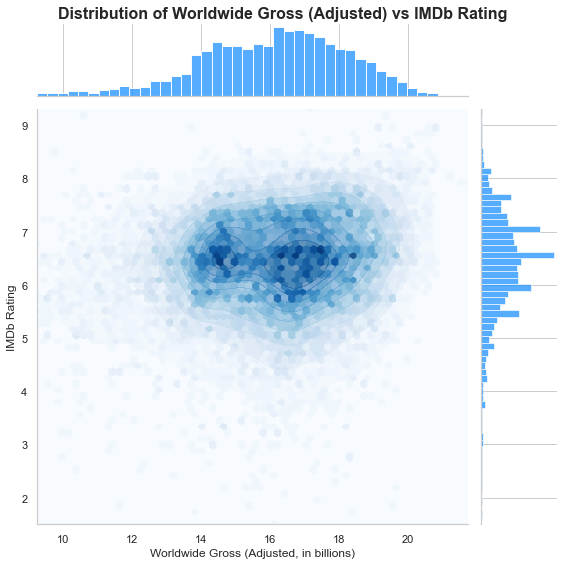

In [26]:
#Display the Adjusted World Gross vs. IMDb Rating plot with the same method when displaying Uadjusted World Gross vs. IMDb Rating plot
cleaned_data['Log_Revenue'] = np.log1p(cleaned_data['Movie box office revenue'])

# Drop rows where 'Log_Revenue' is null (e.g., missing or invalid box office data)
cleaned_data.drop(cleaned_data[cleaned_data['Log_Revenue'].isnull()].index, inplace=True)

# Set Seaborn theme for the plot (white grid and muted color palette)
sns.set_theme(style="whitegrid", palette="muted")

# Create a hexbin jointplot to show the relationship between Adjusted World Gross (Log_Revenue) and IMDb Rating
g = sns.jointplot(data=cleaned_data, x='Log_Revenue', y='averageRating', kind="hex", cmap="Blues", height=8,gridsize=60, marginal_kws=dict(color="dodgerblue"))

# Overlay a KDE (Kernel Density Estimate) plot on the jointplot to show the density distribution
sns.kdeplot(data=cleaned_data, x='Log_Revenue', y='averageRating', cmap="Blues", fill=True, alpha=0.4, ax=g.ax_joint)

# Remove margins on the plot for a tighter fit
g.ax_joint.margins(0) 

# Set the x-axis and y-axis limits based on the data range
g.ax_joint.set_xlim(cleaned_data['Log_Revenue'].min(), cleaned_data['Log_Revenue'].max())
g.ax_joint.set_ylim(cleaned_data['averageRating'].min(), cleaned_data['averageRating'].max())

# Set the title for the plot and adjust font size and position
g.fig.suptitle("Distribution of Worldwide Gross (Adjusted) vs IMDb Rating", fontsize=16, weight='bold', ha='center')

# Set the labels for the x and y axes with appropriate font size
g.set_axis_labels("Worldwide Gross (Adjusted, in billions)", "IMDb Rating", fontsize=12)

# Adjust the layout to make it more compact and prevent label overlap
g.fig.tight_layout()

# Adjust the subplot layout to ensure the title does not overlap with the plot
g.fig.subplots_adjust(top=0.95)

# Display the plot
plt.show()

In [27]:
#Display the Adjusted World Gross vs. IMDb Rating plot with the same method when displaying Uadjusted World Gross vs. IMDb Rating plot
cleaned_data['Log_Revenue'] = np.log1p(cleaned_data['Movie box office revenue'])

# Drop rows where 'Log_Revenue' is null (e.g., missing or invalid box office data)
cleaned_data.drop(cleaned_data[cleaned_data['Log_Revenue'].isnull()].index, inplace=True)

## <font color=DarkTurquoise>Linear Regression</font>

<font color=Gray>We perform a regression of `Log_Revenue` on `averageRating` to get a basic look at the linear relationship between the two. 

**Note:**
It should be noted that this regression likely suffers from omitted variable bias, as we need to consider more factors that could influence both box office revenue and ratings. However, since our dataset is still incomplete (currently being supplemented), this aspect will be addressed in Part 3.</font>

In [28]:
#Perform an Ordinary Least Squares (OLS) regression using the statsmodels library. 
model = smf.ols(formula='Log_Revenue ~ averageRating', data=cleaned_data).fit(cov_type='HC2')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Log_Revenue   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     164.4
Date:                Fri, 15 Nov 2024   Prob (F-statistic):           3.13e-37
Time:                        19:18:16   Log-Likelihood:                -15992.
No. Observations:                7439   AIC:                         3.199e+04
Df Residuals:                    7437   BIC:                         3.200e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.9594      0.169     82.710

<font color=Gray>The regression coefficient for averageRating is **0.3349**, which suggests that for each one-unit increase in averageRating, the Log_Revenue is expected to increase by **0.3349**, holding other factors constant.

**t-Statistic (12.820) and p-Value (0.000):** The high t-statistic and p-value being effectively zero implies that the coefficient is significantly different from zero, reinforcing that averageRating has a statistically significant effect on Log_Revenue.</font>

## <font color=DarkTurquoise>Classification</font>

<font color=Gray>We categorize movies into three types: `those with matched box office and ratings`, `high box office with low ratings`, and `low box office with high ratings`. We are particularly interested in understanding the factors behind the latter two categories. 

The first issue to address is how to distinguish these three types. Our approach is to shift the regression line up and down by one standard deviation, dividing the plane into three regions. Points in the upper left (above the **green line**) are considered `Overperformed`  (high box office with low ratings), those in the lower right (lower than the **red line**) are `Underperformed` (low box office with high ratings), and points between the two lines fall into the **matched category**.</font>

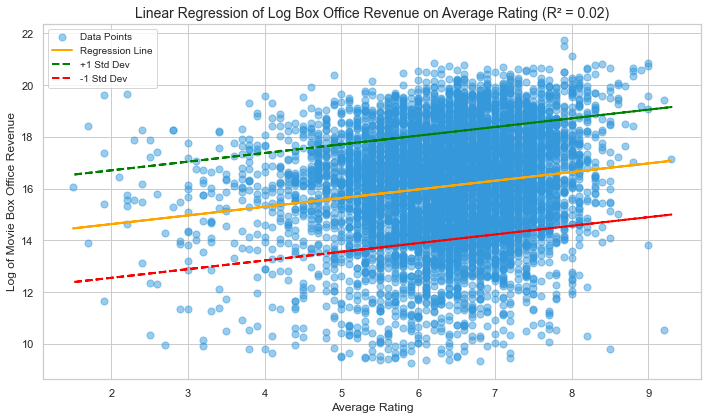

In [30]:
# Calculate the coefficients, predictions, and standard deviation
coefficients = model.params
predictions = model.predict()
std_dev = np.std(predictions - cleaned_data['Log_Revenue'])
r2_score = model.rsquared_adj

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_data['averageRating'], cleaned_data['Log_Revenue'], 
            color='#3498DB', alpha=0.5, s=50, label='Data Points')

# Regression line
plt.plot(cleaned_data['averageRating'], predictions, color='orange', linewidth=2, label='Regression Line')

# Standard deviation lines
plt.plot(cleaned_data['averageRating'], predictions + std_dev, color='green', linestyle='--', linewidth=2, label='+1 Std Dev')
plt.plot(cleaned_data['averageRating'], predictions - std_dev, color='red', linestyle='--', linewidth=2, label='-1 Std Dev')

# Add labels and title
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Log of Movie Box Office Revenue', fontsize=12)
plt.title(f'Linear Regression of Log Box Office Revenue on Average Rating (R² = {r2_score:.2f})', fontsize=14)
plt.legend(loc='upper left', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

Interactive version below (needs downloading; static plot should be enough from direct git viewing)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
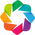

:Overlay
   .Scatter.I                    :Scatter   [averageRating]   (Log_Revenue)
   .Curve.Regression_Line        :Curve   [x]   (y)
   .Curve.Plus_1_Std_Dev         :Curve   [x]   (y)
   .Curve.Hyphen_minus_1_Std_Dev :Curve   [x]   (y)

In [123]:
# Load the 'bokeh' extension for plotting
hv.extension('bokeh')  

# Calculate the coefficients, predictions, and standard deviation
coefficients = model.params
predictions = model.predict()
std_dev = np.std(predictions - cleaned_data['Log_Revenue'])

# Create the plot with improved style and readability
scatter = hv.Scatter(cleaned_data, 'averageRating', 'Log_Revenue').opts(
    color='#3498DB', size=7, alpha=0.5, tools=['hover'], xlabel='Average Rating', ylabel='Log of Movie Box Office Revenue'
)

# Regression line and Standard Deviation lines
regression_line = hv.Curve((cleaned_data['averageRating'], predictions), label='Regression Line').opts(color='orange', line_width=2)
std_dev_line_upper = hv.Curve((cleaned_data['averageRating'], predictions + std_dev), label='+1 Std Dev').opts(color='green', line_dash='dashed', line_width=2)
std_dev_line_lower = hv.Curve((cleaned_data['averageRating'], predictions - std_dev), label='-1 Std Dev').opts(color='red', line_dash='dashed', line_width=2)

# Integrate plots
layout = (scatter * regression_line * std_dev_line_upper * std_dev_line_lower).opts(
    title='Linear Regression of Log Box Office Revenue on Average Rating',
    width=800, height=500, legend_position='top_left'
)

layout


<font color=Gray>We aim to further examine the regression and classification for each country. The plots are shown below:

We can observe that:

(1) Most movies originate from the United States, France, South Korea, and the United Kingdom, while scatter plots for other countries are relatively sparse.

(2) In most countries, box office revenue tends to increase with higher ratings. The slope is particularly steep for the United States, the United Kingdom, Canada, Australia, and Hong Kong.</font>

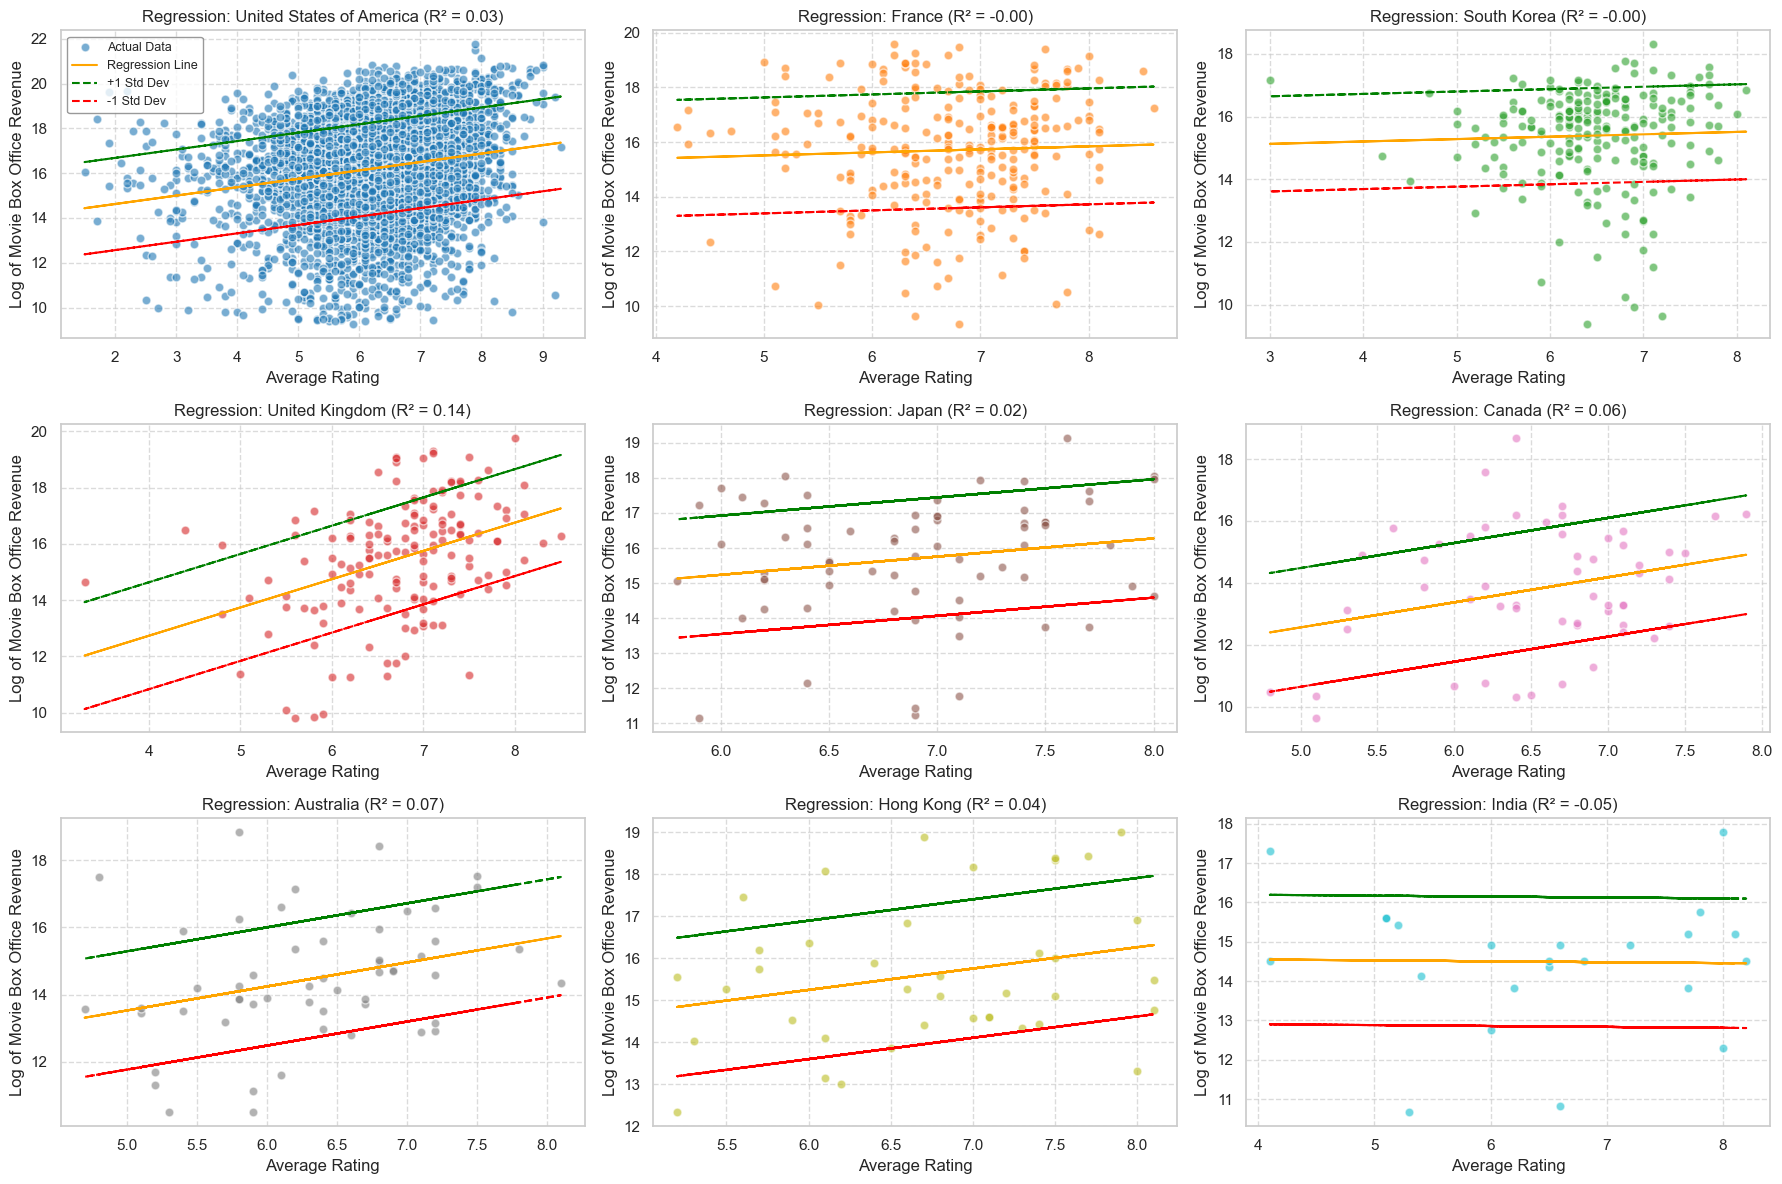

In [124]:
# Select the top 9 countries with the highest movie counts and get their names in a list
selected_countries = cleaned_data['Primary Country'].value_counts().sort_values(ascending=False).head(9).index.tolist()

# Filter the data to include only the selected countries
subset = cleaned_data[cleaned_data['Primary Country'].isin(selected_countries)]

# Generate a color palette for each country based on the number of selected countries
colors_countries = plt.cm.tab10(np.linspace(0, 1, len(selected_countries)))

# Set up the figure size for the plot
plt.figure(figsize=(18, 12))

# Loop through each selected country and create a subplot for each
for i, country in enumerate(selected_countries, 1):
    plt.subplot(3, 3, i)  
    country_data = subset[subset['Primary Country'] == country]  

    # Perform OLS regression for Log_Revenue based on averageRating for the current country
    model_countries = smf.ols(formula='Log_Revenue ~ averageRating', data=country_data).fit(cov_type='HC2')
    coefficients_countries = model_countries.params  
    predictions_countries = model_countries.predict()  
    r2_score_countries = model_countries.rsquared_adj  

    # Calculate the standard deviation of residuals for the regression model
    std_dev_countries = np.std(predictions_countries - country_data['Log_Revenue'])

    # Plot actual data points with unique color for each country
    plt.scatter(country_data['averageRating'], country_data['Log_Revenue'], color=colors_countries[i - 1], alpha=0.6, s=40, edgecolor='white', label='Actual Data')

    # Plot the regression line for the model
    plt.plot(country_data['averageRating'], predictions_countries, color='orange', label='Regression Line')

    # Plot lines for +1 and -1 standard deviations from the regression line
    plt.plot(country_data['averageRating'], predictions_countries + std_dev_countries, color='green', linestyle='--', label='+1 Std Dev')
    plt.plot(country_data['averageRating'], predictions_countries - std_dev_countries, color='red', linestyle='--', label='-1 Std Dev')

    # Set labels and title for the subplot
    plt.xlabel('Average Rating')
    plt.ylabel('Log of Movie Box Office Revenue')
    plt.title(f'Regression: {country} (R² = {r2_score_countries:.2f})')

    # Add grid lines for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add legend only for the first subplot
    if i == 1:  
        plt.legend(fontsize=9, loc='upper left', frameon=True, framealpha=0.8, edgecolor='gray')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the entire set of subplots
plt.show()


<font color=Gray>We aim to further examine the regression and classification for ten time points (from 1915 to 2015). The plots are shown below:

We can observe that:

(1) From the overall trend, the number of movies has been increasing in recent years, which is reflected by the growing number of points in the scatter plots.

(2) The regression curves for nearly all years show an upward trend, indicating that box office revenue increases as ratings rise.
</font>

c:\Anaconda3\envs\ada\Lib\site-packages\statsmodels\regression\linear_model.py:1795: RuntimeWarning: invalid value encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Anaconda3\envs\ada\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Anaconda3\envs\ada\Lib\site-packages\statsmodels\regression\linear_model.py:2003: RuntimeWarning: divide by zero encountered in divide
  self.het_scale = self.wresid**2/(1-h)


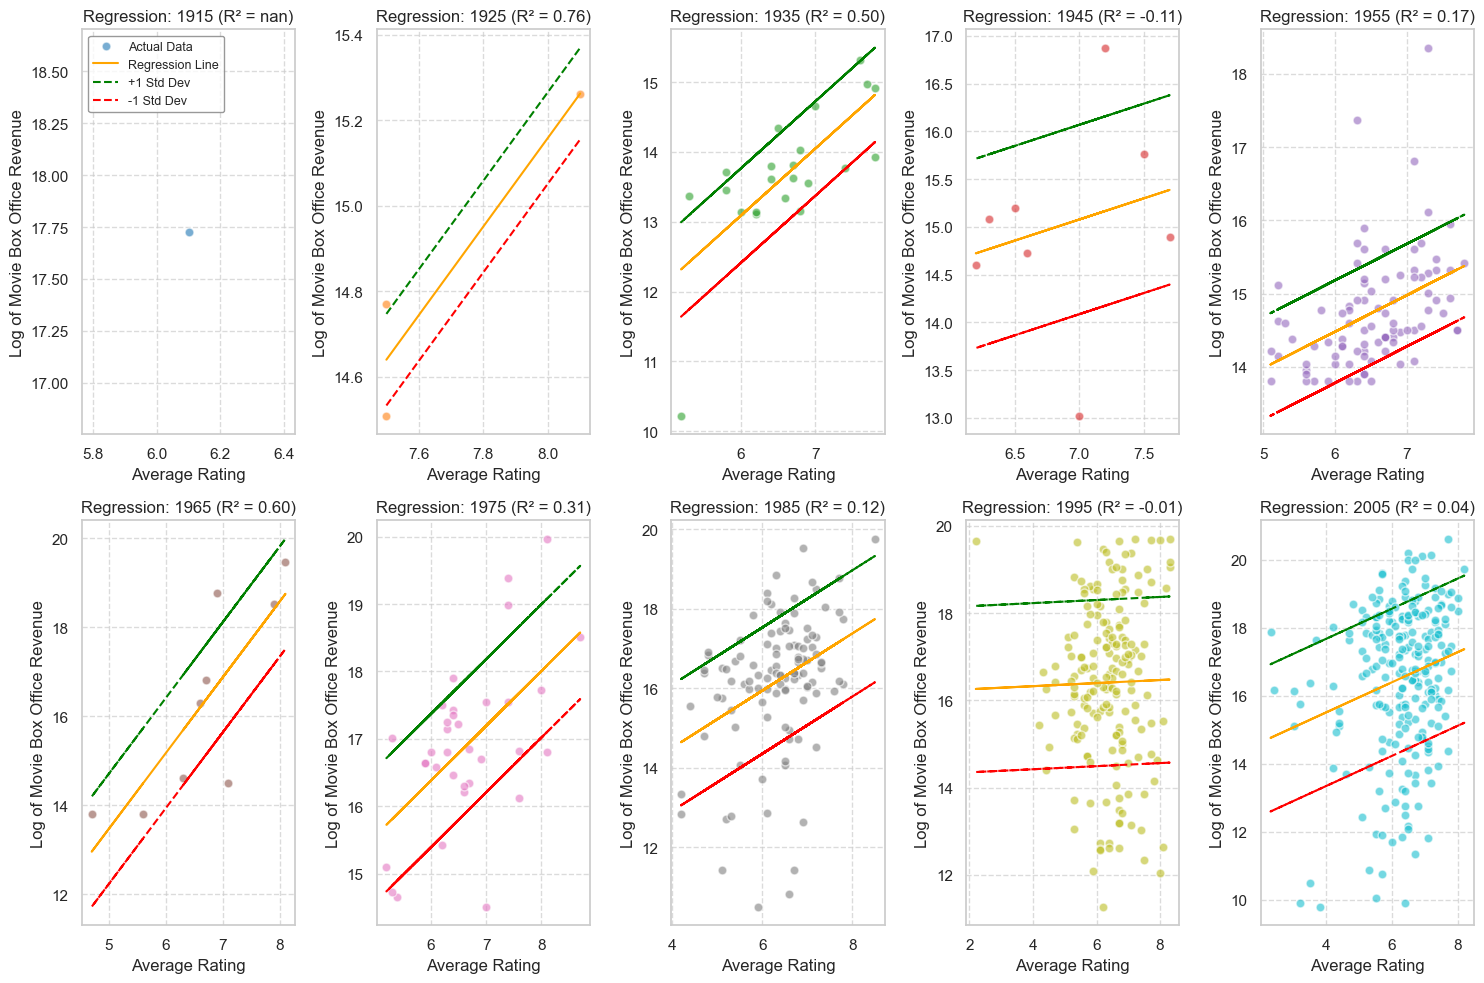

In [125]:
# Find the maximum year in the dataset for reference
cleaned_data['Year'].max()

# Define the range of selected years, starting from 1915 and selecting every 10 years up to 2015
selected_years = range(1915, 2015, 10)

# Subset the data to only include rows where the year is in the selected years
subset = cleaned_data[cleaned_data['Year'].isin(selected_years)]

# Generate a color palette for each year based on the number of selected years
colors_years = plt.cm.tab10(np.linspace(0, 1, len(selected_years)))

# Set up the figure size for the plot
plt.figure(figsize=(15, 10))

# Loop through each selected year and create a subplot for each
for i, year in enumerate(selected_years, 1):
    plt.subplot(2, 5, i)  
    year_data = subset[subset['Year'] == year] 

    # Perform OLS regression for Log_Revenue based on averageRating for the current year
    model_years = smf.ols(formula='Log_Revenue ~ averageRating', data=year_data).fit(cov_type='HC2')
    coefficients_years = model_years.params  
    predictions_years = model_years.predict()  
    r2_score_years = model_years.rsquared_adj  

    # Calculate the standard deviation of residuals for the regression model
    std_dev_years = np.std(predictions_years - year_data['Log_Revenue'])

    # Plot actual data points with unique color for each year
    plt.scatter(year_data['averageRating'], year_data['Log_Revenue'], color=colors_years[i - 1], alpha=0.6, s=40, edgecolor='white', label='Actual Data')

    # Plot the regression line for the model
    plt.plot(year_data['averageRating'], predictions_years, color='orange', label='Regression Line')

    # Plot lines for +1 and -1 standard deviations from the regression line
    plt.plot(year_data['averageRating'], predictions_years + std_dev_years, color='green', linestyle='--', label='+1 Std Dev')
    plt.plot(year_data['averageRating'], predictions_years - std_dev_years, color='red', linestyle='--', label='-1 Std Dev')

    # Set labels and title for the subplot
    plt.xlabel('Average Rating')
    plt.ylabel('Log of Movie Box Office Revenue')
    plt.title(f'Regression: {year} (R² = {r2_score_years:.2f})')

    # Add grid lines for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add legend only for the first subplot
    if i == 1:
        plt.legend(fontsize=9, loc='upper left', frameon=True, framealpha=0.8, edgecolor='gray')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the entire set of subplots
plt.show()


## <font color=DarkTurquoise>Overperformed VS Underperformed</font>

<font color=Gray>We can see that the number of movies defined as `Overperformed` is **1231**, while the number of movies defined as `Underperformed` is **1139**.</font>

In [126]:
# Calculate residuals by subtracting predictions from the actual Log_Revenue values
residuals = cleaned_data['Log_Revenue'] - predictions

# Identify outliers where the absolute value of residuals is greater than the standard deviation
outliers = cleaned_data[np.abs(residuals) > std_dev]['Log_Revenue']
print(outliers.count())  

# Separate data into two categories: higher and lower outliers
higher = cleaned_data[residuals > std_dev].copy()

# 'lower' contains rows where residuals are less than negative one standard deviation (negative outliers)
lower = cleaned_data[residuals < -std_dev].copy()

# Print the number of higher and lower outliers
print('length of higher:', len(higher), 'length of lower:', len(lower))


2370
length of higher: 1231 length of lower: 1139


<font color=Gray>Next, we examine the genre distribution of these two categories of movies separately. In our dataset, each movie’s genre is represented as a list, with the first genre indicating the primary category. We will start by analyzing the number of movies in each genre, sorting them from highest to lowest. Then, we will assess the percentage of each genre when it appears as the `first genre`, `second genre`, and `third genre`. We adopt this approach because we recognize all three genre slots might be important and that overlapping might exist between different genre slots, thus we aim to capture genre information as comprehensively as possible.</font>

In [127]:
# Calculate residuals between actual and predicted values
residuals = cleaned_data['Log_Revenue'] - predictions

# Identify outliers where the absolute residual is greater than the standard deviation
outliers = cleaned_data[np.abs(residuals) > std_dev]['Log_Revenue']

# Separate data into high residuals (above +std_dev) and low residuals (below -std_dev)
higher = cleaned_data[residuals > std_dev].copy()
lower = cleaned_data[residuals < -std_dev].copy()

# Extract the first, second, and third genres for each movie in 'higher'
higher.loc[:, 'First genre'] = higher['Movie genres'].apply(lambda x: x[0] if len(x) > 0 else None)  # First genre
higher.loc[:, 'Second genre'] = higher['Movie genres'].apply(lambda x: x[1] if len(x) > 1 else None)  # Second genre, if available
higher.loc[:, 'Third genre'] = higher['Movie genres'].apply(lambda x: x[2] if len(x) > 2 else None)  # Third genre, if available

# Extract the first, second, and third genres for each movie in 'lower'
lower.loc[:, 'First genre'] = lower['Movie genres'].apply(lambda x: x[0] if len(x) > 0 else None)  # First genre
lower.loc[:, 'Second genre'] = lower['Movie genres'].apply(lambda x: x[1] if len(x) > 1 else None)  # Second genre, if available
lower.loc[:, 'Third genre'] = lower['Movie genres'].apply(lambda x: x[2] if len(x) > 2 else None)  # Third genre, if available

# Count occurrences of each genre in the first, second, and third positions in 'higher'
First_t10_h = higher['First genre'].value_counts()   # Top 10 first genres in higher residuals
Second_t10_h = higher['Second genre'].value_counts()  # Top 10 second genres in higher residuals
Third_t10_h = higher['Third genre'].value_counts()    # Top 10 third genres in higher residuals

# Count occurrences of each genre in the first, second, and third positions in 'lower'
First_t10_l = lower['First genre'].value_counts()   # Top 10 first genres in lower residuals
Second_t10_l = lower['Second genre'].value_counts()  # Top 10 second genres in lower residuals
Third_t10_l = lower['Third genre'].value_counts()    # Top 10 third genres in lower residuals

# Combine all genres (first, second, and third positions) for an overall top 10 in 'higher'
all_genres_h = pd.concat([higher['First genre'], higher['Second genre'], higher['Third genre']])
All_t10_h = all_genres_h.value_counts().head(10)  # Top 10 genres overall for higher residuals

# Combine all genres (first, second, and third positions) for an overall top 10 in 'lower'
all_genres_l = pd.concat([lower['First genre'], lower['Second genre'], lower['Third genre']])
All_t10_l = all_genres_l.value_counts().head(10)  # Top 10 genres overall for lower residuals

# Initialize an array to store genre counts by position in 'higher'
data_h = np.zeros((len(All_t10_h.index), 3))  # Array with rows as genres and 3 columns for positions
i = 0

# Populate 'data_h' with genre counts from the top 10 genres in each position in 'higher'
for genre in All_t10_h.index:
    data_h[i, 0] = First_t10_h.get(genre, 0)  # Count in first genre position
    data_h[i, 1] = Second_t10_h.get(genre, 0)  # Count in second genre position
    data_h[i, 2] = Third_t10_h.get(genre, 0)   # Count in third genre position
    i += 1

# Initialize an array to store genre counts by position in 'lower'
data_l = np.zeros((len(All_t10_l.index), 3))  # Array with rows as genres and 3 columns for positions
i = 0

# Populate 'data_l' with genre counts from the top 10 genres in each position in 'lower'
for genre in All_t10_l.index:
    data_l[i, 0] = First_t10_l.get(genre, 0)  # Count in first genre position
    data_l[i, 1] = Second_t10_l.get(genre, 0)  # Count in second genre position
    data_l[i, 2] = Third_t10_l.get(genre, 0)   # Count in third genre position
    i += 1


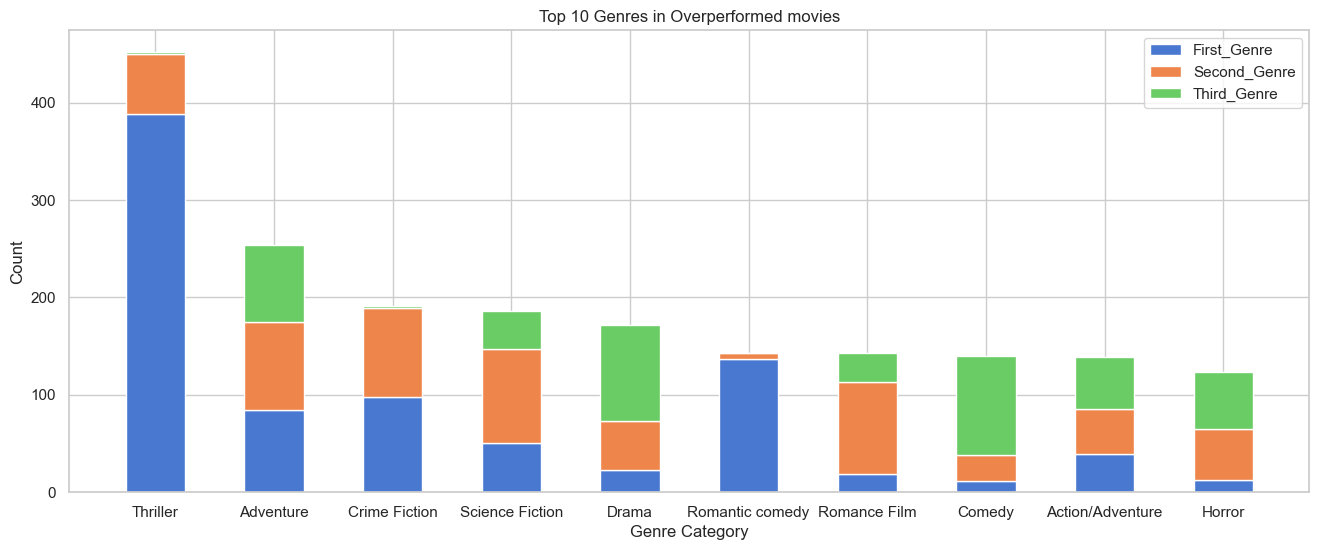

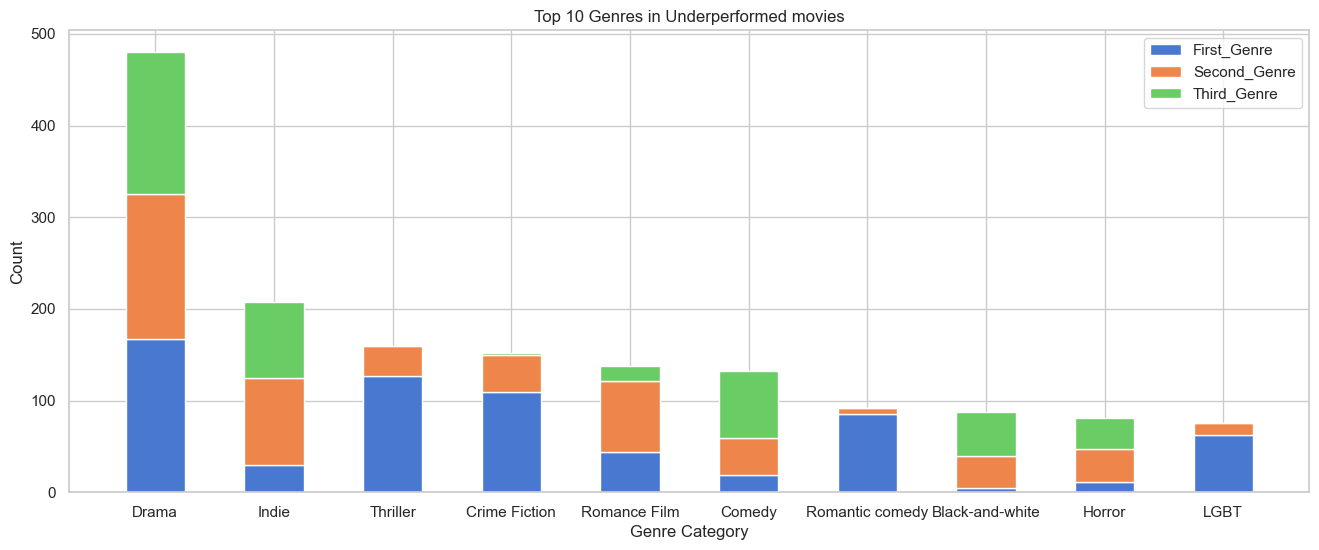

In [128]:
categories_h = All_t10_h.index
subcategories_h = ['First_Genre', 'Second_Genre', 'Third_Genre']
categories_l = All_t10_l.index
subcategories_l = ['First_Genre', 'Second_Genre', 'Third_Genre']

# Set bar width and index offset
bar_width = 0.5
index_h = np.arange(len(categories_h))

# Set figure size
plt.figure(figsize=(16, 6))

# Plot data for each subcategory in a stacked bar chart
for i in range(len(subcategories_h)):
    plt.bar(index_h, data_h[:, i], bar_width, label=subcategories_h[i], bottom=np.sum(data_h[:, :i], axis=1))

# Add labels and title
plt.xlabel('Genre Category')
plt.ylabel('Count')
plt.title('Top 10 Genres in Overperformed movies')
plt.xticks(index_h, categories_h)
plt.legend()

# Display the plot
plt.show()

index_l = np.arange(len(categories_l))

# Set figure size
plt.figure(figsize=(16, 6))

# Plot data for each subcategory in a stacked bar chart
for i in range(len(subcategories_l)):
    plt.bar(index_l, data_l[:, i], bar_width, label=subcategories_l[i], bottom=np.sum(data_l[:, :i], axis=1))

# Add labels and title
plt.xlabel('Genre Category')
plt.ylabel('Count')
plt.title('Top 10 Genres in Underperformed movies')
plt.xticks(index_l, categories_l)
plt.legend()

# Display the plot
plt.show()

Interpretion: The above bar charts allow us to see the distribution of genres listed as "first", "second", and "third" genres slots, as well as distribution of genres in general since the ordering might not be semantically significant in the first place. A promising finding is that the *Thriller* genre appears to outclass the other genres in numbers among overperforming movies, while the same appears to hold true for the *Drama* genre among underperforming ones. This potentially indicates audience taste, and the factors (actors, etc.) that might've contributed to, or potentially even confounded, these results can be subject to further analysis later in the project.

<font color=Gray>Please also find below the interactive version of the movie genre distribution chart (download might be needed; non-interactive version should be sufficient for direct viewing from git).</font>

In [129]:
categories = list(All_t10_h.index)
values = np.concatenate([data_h[:, 0], data_h[:, 1], data_h[:, 2]])

# Ensure all arrays have the same length
data_dict = {
    'Category': np.tile(categories, 3),  
    'Subcategory': ['First_Genre'] * len(categories) + ['Second_Genre'] * len(categories) + ['Third_Genre'] * len(categories),
    'Value': values
}
df = pd.DataFrame(data_dict)

# Custom color mapping
color_map = {
    'First_t10': '#800080',   
    'Second_t10': '#00008B',  
    'Third_t10': '#87CEFA'    
}

# Create stacked bar chart
bars = hv.Bars(df, ['Category', 'Subcategory'], 'Value')

# Set chart style
bars.opts(
    stacked=True,                      
    width=1000, height=500,            
    color=hv.Cycle(values=[color_map['First_t10'], color_map['Second_t10'], color_map['Third_t10']]), 
    title='Top 10 Genres in Reality higher than Prediction',
    tools=['hover'],                  
    toolbar='above',                   
    legend_position='top',             
    xrotation=45,                      
    padding=0.1                        
)

bars


:Bars   [Category,Subcategory]   (Value)

In [130]:
categories = list(All_t10_l.index)
values = np.concatenate([data_l[:, 0], data_l[:, 1], data_l[:, 2]])

# Ensure all arrays have the same length
data_dict = {
    'Category': np.tile(categories, 3),  # Repeat categories 3 times
    'Subcategory': ['First_Genre'] * len(categories) + ['Second_Genre'] * len(categories) + ['Third_Genre'] * len(categories),
    'Value': values
}
df = pd.DataFrame(data_dict)

# Custom color mapping
color_map = {
    'First_t10': '#800080',   
    'Second_t10': '#00008B',  
    'Third_t10': '#87CEFA'    
}

# Create stacked bar chart
bars = hv.Bars(df, ['Category', 'Subcategory'], 'Value')

# Set chart style
bars.opts(
    stacked=True,                      
    width=1000, height=500,            
    color=hv.Cycle(values=[color_map['First_t10'], color_map['Second_t10'], color_map['Third_t10']]), 
    title='Top 10 Genres in Reality lower than Prediction',
    tools=['hover'],                  
    toolbar='above',                   
    legend_position='top',             
    xrotation=45,                      
    padding=0.1                        
)

bars


:Bars   [Category,Subcategory]   (Value)

# Rejected Methologie(s)

One initially considered method to categorize/cluster movies into categories, two of which of our interest would've been "movies that perform well financially but received bad critical review" and "movies that underperformed financially but received critical acclaim", is to use straight-forward k-means clustering. This is abandoned since we discovered that the two-dimensional (box office vs rating) plotting of all movies are fairly continuous and does not lend itself well to discrete clustering. Hence the more generalized, standard deviation-based "overperformers" and "underperformers" categories we did end up using. Below is a visualization of different clusters.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

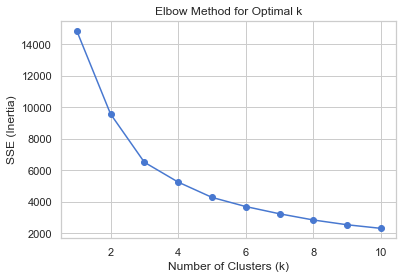

In [32]:
# Finding sum-of-squared-errors elbow to determine the best k number for clustering
from sklearn.cluster import KMeans
x=cleaned_data['averageRating']
x = (x -x.mean())/x.std()
y=cleaned_data['Log_Revenue']
y = (y -y.mean())/y.std()
cleaned_data['averageRating'] = (x - np.min(x)) / (np.max(x) - np.min(x))
cleaned_data['Log_Revenue'] = (y - np.min(y)) / (np.max(y) - np.min(y))
data = np.column_stack((x, y))
# #elbow
sse = []
k_range = range(1, 11)  
for k in k_range:
     kmeans = KMeans(n_clusters=k, random_state=42)
     kmeans.fit(data)
     sse.append(kmeans.inertia_)  
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.show()

(k = 4 seems like a good elbow point, clustering using 4 k-means clusters below)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


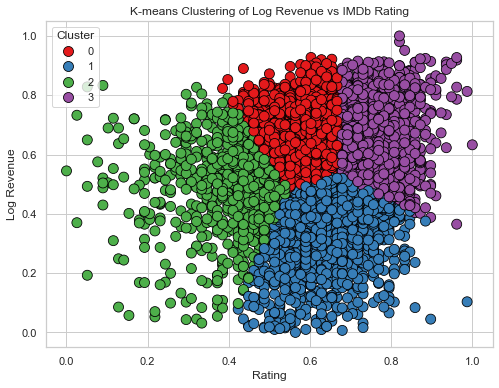

In [33]:
kmeans = KMeans(n_clusters=4, random_state=42)  
cleaned_data['cluster'] = kmeans.fit_predict(data)  
plt.figure(figsize=(8, 6))
sns.scatterplot(x='averageRating', y='Log_Revenue', hue='cluster', palette='Set1', data=cleaned_data, s=100, edgecolor='black', marker='o')
plt.title('K-means Clustering of Log Revenue vs IMDb Rating')
plt.xlabel('Rating')
plt.ylabel('Log Revenue')
plt.legend(title='Cluster')
plt.show()

Interpretation: Ideal positions for clusters that correspond to "movies that perform well financially but received bad critical review" and "movies that underperformed financially but received critical acclaim", respectively, would've ideally been confined to top-left and bottom-right quadrants respectively. Which even for k = 4 is not the case for the actual dataset.